In [86]:
import imageio 
from matplotlib import pyplot as plt
from skimage import data, io
import ipywidgets as widgets
from ipywidgets import Button, Layout
import cv2
from skimage import data, io, filters, exposure
import skimage.morphology as mp
import numpy as np
from skimage.filters import roberts, sobel, scharr, prewitt, frangi, try_all_threshold, threshold_otsu, threshold_local
from skimage import img_as_float
from skimage.color import rgb2hsv, hsv2rgb, rgb2gray
import cv2
import numpy as np
from skimage.morphology import disk, dilation, erosion
from scipy.stats import moment
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.patches as mpatches
from sklearn.neighbors import KNeighborsClassifier
from skimage.exposure import equalize_adapthist
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm



In [2]:
style = {'description_width': '40%'}

selector = widgets.Dropdown(
    options=[('Test eye 1', ['photos/Image_01L.jpg','photos/Image_01L_1stHO.png']),
             ('Test eye 2', ['photos/Image_02L.jpg','photos/Image_02L_1stHO.png']),
             ('Test eye 3', ['photos/Image_11L.jpg','photos/Image_11L_1stHO.png']),
             ('Test eye 4', ['photos/Image_13L.jpg','photos/Image_13L_1stHO.png']),
             ('Test eye 5', ['photos/Image_08R.jpg','photos/Image_08R_1stHO.png']),
             ('Healthy eye 1', 'photos/01_h.jpg'), ('Healthy eye 2', 'photos/02_h.jpg'),
             ('Healthy eye 3', 'photos/03_h.jpg'), ('Healthy eye 4', 'photos/04_h.jpg'),
            ('Healthy eye 5', 'photos/05_h.jpg'), ('Healthy eye 6', 'photos/06_h.jpg'),
            ('Healthy eye 7', 'photos/07_h.jpg'), ('Healthy eye 8', 'photos/08_h.jpg'), 
            ('Healthy eye 9', 'photos/09_h.jpg'), ('Healthy eye 10', 'photos/010_h.jpg'),
            ('Healthy eye 11', 'photos/011_h.jpg'), ('Healthy eye 12', 'photos/012_h.jpg'), 
            ('Healthy eye 13', 'photos/013_h.jpg'), ('Healthy eye 14', 'photos/014_h.jpg'), 
            ('Healthy eye 15', 'photos/015_h.jpg')],
    value=['photos/Image_01L.jpg','photos/Image_01L_1stHO.png'],
    description='Image:',
    layout=Layout(width='50%', height='30px'),
    style=style
)

display(selector)

Dropdown(description='Image:', layout=Layout(height='30px', width='50%'), options=(('Test eye 1', ['photos/Ima…

In [75]:
#image =cv2.imread(selector.value[0])
def create_mask(image):
    img = rgb2gray(image)
    img[img[:, :] > 0.05] = 1
    img[img[:, :] <= 0.05] = 0
    img = mp.erosion(img, disk(1))
    img = mp.dilation(img, disk(3))
    img = erosion(img, disk(3))
    return img

def image(img):
    mask = create_mask(cv2.imread(img))
    img = cv2.imread(img,0)
    equ = cv2.equalizeHist(img)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(img)
    block_size = 213
    adaptive_thresh = threshold_local(cl1, block_size, offset=10)
    binary_adaptive = cl1 > adaptive_thresh
    binary_adaptive = mp.dilation(mp.dilation(mp.dilation(mp.erosion(binary_adaptive))))
    binary_adaptive[mask == 0 ] = 1
    exit = np.zeros(binary_adaptive.shape)
    exit[binary_adaptive == True] = 0
    exit[binary_adaptive == False] = 1    
    exit = dilation(exit)
    return exit


def confusion_matrix(image, mask):
    result = []
    tp = 0
    fp = 0
    fn = 0
    tn = 0
    for i in range(len(image)):
        row = []
        for j in range(len(image[i])):
            if (image[i][j] == 1.0):
                if (mask[i][j] == 1.0):
                    row.append([0, 255, 0]) #zielony
                    tp+=1
                elif (mask[i][j] == 0.0):
                    row.append([255, 0, 0]) #czerwony
                    fp+=1
            elif (image[i][j] == 0.0):
                if (mask[i][j] == 1.0):
                    row.append([0, 0, 255]) #niebieski
                    fn+=1
                elif (mask[i][j] == 0.0):
                    row.append([255, 255, 255]) #biały
                    tn+=1
        result.append(row)
    return result, tp, fp, fn, tn


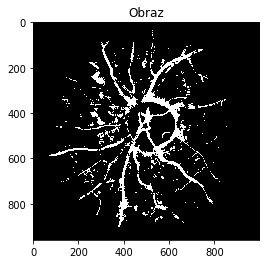

In [76]:
a = image(selector.value[0])
plt.title('Obraz')
plt.imshow(a, cmap = plt.cm.gray)

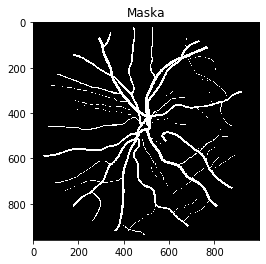

In [77]:
mask = rgb2gray(cv2.imread(selector.value[1]))
plt.title('Maska')
plt.imshow(mask, cmap = plt.cm.gray)

In [78]:
def create_matrix (img, hand):
    res, tp, fp, fn, tn = confusion_matrix(img, hand)

    #czułość
    tpr = tp / (tp + fn)
    #trafność
    ppv = (tp + tn) / (tn + fn + tp + fp)
    #swoistość
    spc = tn / (fp + tn)

    avg = (spc + tpr) / 2
    print("trafność:", ppv)
    print("czułość:", tpr)
    print("swoistość:", spc)
    print("średnia arytmetyczna czułości i swoistości:", avg)
    plt.title('Macierz pomyłek')
    red_patch = mpatches.Patch(color='red', label='FP')
    blue_patch = mpatches.Patch(color='blue', label='FN')
    white_patch = mpatches.Patch(color='white', label='TN')
    green_patch = mpatches.Patch(color='green', label='TP')
    plt.legend(handles=[red_patch, blue_patch,white_patch, green_patch], loc='center left', bbox_to_anchor=(1, 0.5))
    plt.imshow(res)

In [143]:
def get_features(img):
    cen_moments_2 = []
    cen_moments_3 = []
    cen_moments_4 = []
    cen_moments_5 = []
    for i in range(len(img)// 5):
        for j in range(len(img[0]) // 5):
            part_img = img [5*i:5*(i+1), 5*j:5*(j+1)].flatten()
            cen_moments_2.append(moment(part_img, moment = 2))
            cen_moments_3.append(moment(part_img, moment = 3))
            cen_moments_4.append(moment(part_img, moment = 4))
            cen_moments_5.append(moment(part_img, moment = 5))
    return list(zip(cen_moments_2, cen_moments_3, cen_moments_4, cen_moments_5))

def get_labels(img):
    label = [] 
    for i in range(len(img) // 5):
        for j in range(len(img[0]) // 5):
            img_part = img[5*i : 5*(i+1), 5*j : 5*(j+1)]
            label.append(img_part[2,2])
    return label


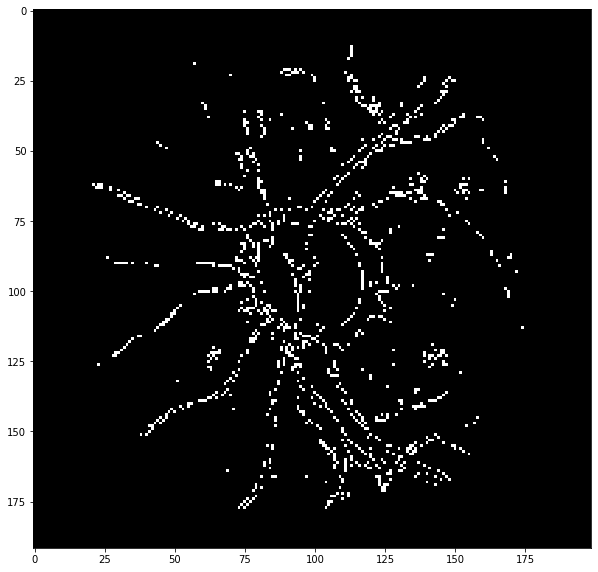

In [183]:
img  = image("photos/Image_03L.jpg")
hand = img_as_float(cv2.imread("photos/Image_03L_1stHO.png",0))
X = get_features(img)
y = get_labels(hand)
check = get_features(image('photos/Image_02L.jpg'))
clf = DecisionTreeClassifier(criterion = "entropy")
clf.fit(X,y)
predicted1 = clf.predict(check)

x, y1 = img.shape
predicted = np.array_split(predicted1, x // 5)
plt.figure(figsize=(10, 10))
plt.imshow(predicted, cmap=plt.cm.gray)

In [184]:
pre = []
y1 = y1 // 5
k = 0
for i in range(x//5):
    pre.append([])
    for j in range(y1):
        pre[i] += [predicted1[k]]
        k += 1
    
    


# y1

In [185]:
y1

199

In [186]:
pre

[[0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,

In [150]:
y1//5

199

In [172]:
a = predicted1[1]

In [173]:
a

0.0

In [187]:
create_matrix(pre, get_labels(img_as_float(plt.imread('photos/Image_03L_1stHO.png'))))

IndexError: invalid index to scalar variable.